# Sonar Visualization Playground

Quick-start notebook to run the 2D sonar simulator, view wavefields inline, and export GIFs for report/presentation assets.

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams['animation.embed_limit'] = 50  # MB, pick your size

from IPython.display import HTML, Image

from setup_sonar_model import setup_sonar_model, print_model_info
from simpleLeapFrog import LeapfrogSolver
from sonar_viz import plot_pressure_xz_at
from create_wave_animation import create_wave_animation


## Run a baseline simulation
Configure a moderate grid and stable timestep (fraction of CFL). Adjust `Nx/Nz` or `t_extra` for larger domains or longer runs.

In [2]:
def run_simulation(Nx=200, Nz=50, Lz=500, f0=20, t_extra=0.2, dt_scale=0.5):
    """Run sonar simulation and return state history"""
    # enforce square cells: set Lx from Lz and grid sizes
    Lx = Lz * (Nx - 1) / (Nz - 1)

    hydro_config = {
        "x_indices": [50, 75, 100, 125, 150],
        "z_indices": [15, 20, 25, 30, 35],
        "n_phones": 5
    }
    source_pos = (90, 15)

    model = setup_sonar_model(
        Nx=Nx, Nz=Nz, Lx=Lx, Lz=Lz, f0=f0, t_extra=t_extra,
        source_position=source_pos, hydrophone_config=hydro_config
    )
    dt = dt_scale * model['max_dt_FE']
    num_steps = int(np.ceil((model['t_stop'] - model['t_start']) / dt))
    print_model_info(model, verbose=False)
    print(f"Using dt = {dt:.3e} s with {num_steps} steps")
    X, t = LeapfrogSolver(model['eval_f'], model['x_start'], model['p'], model['eval_u'], num_steps, dt, visualize=False, verbose=False)
    return {"model": model, "X": X, "t": t}

# Run a default scenario
sim = run_simulation()


SONAR MODEL CONFIGURATION

Grid: 200 × 50 = 10,000 cells
Domain: 2031m × 500m
Spacing: dx = 10.2041m, dz = 10.2041m

Acoustic Properties:
  Sound speed: c = 1500.0 m/s
  Frequency: f₀ = 20 Hz
  Wavelength: λ = 75.00m
  Resolution: 7.4 points per wavelength
  Domain coverage: 27.1λ × 6.7λ

Source Position:
  Grid indices: (90, 15)
  Physical: x = 918.4m, z = 153.1m

Hydrophones: 5 receivers
  Type: Custom paired hydrophones (x,z):
    H1: x = 510.2m, z = 153.1m
    H2: x = 765.3m, z = 204.1m
    H3: x = 1020.4m, z = 255.1m
    H4: x = 1275.5m, z = 306.1m
    H5: x = 1530.6m, z = 357.1m

Time Integration:
  Time span: 0.000s to 1.554s (1553.7ms)
  Max stable dt (CFL): 2405.13 μs

State Vector: 20,000 DOFs
Using dt = 1.203e-03 s with 1293 steps
Running Leapfrog solver (stable for wave equations)...


## Single-frame snapshot
Inspect the pressure field at a chosen time (ms).

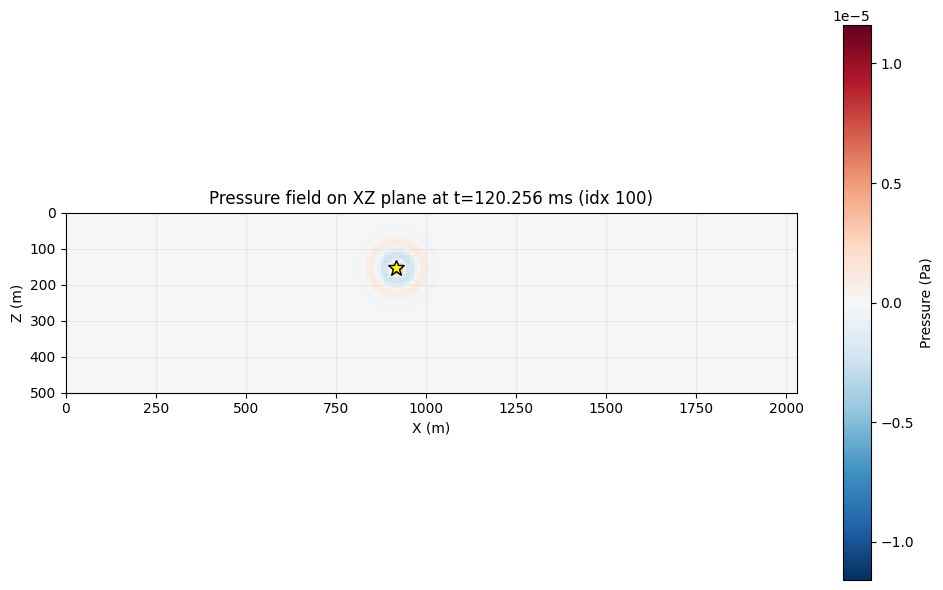

In [3]:
# Plot near the first surface reflection; tweak time_s as needed
_ = plot_pressure_xz_at(sim['model']['p'], sim['X'], sim['t'], time_s=0.12)


## Fast GIF writer (imageio)
Bypass Matplotlib animation and write frames directly. Adjust `frame_skip`/`max_frames`/`fps` to trade speed vs. smoothness.

In [4]:
import imageio.v2 as imageio
import matplotlib.cm as cm

def save_gif_fast(sim, gif_path, frame_skip=4, max_frames=300, fps=12, cmap_name="RdBu_r"):
    p = sim['model']['p']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    pressure = sim['X'][:N, :].reshape(Nx, Nz, -1)
    v_abs = float(np.max(np.abs(pressure))) if pressure.size else 1.0
    cmap = cm.get_cmap(cmap_name)

    frames = []
    # Limit frames to keep runtime reasonable
    max_idx = min(pressure.shape[2], frame_skip * max_frames)
    for i in range(0, max_idx, frame_skip):
        frame = pressure[:, :, i].T
        norm = (frame + v_abs) / (2 * v_abs + 1e-12)  # map [-v_abs, v_abs] -> [0,1]
        rgba = (cmap(np.clip(norm, 0, 1)) * 255).astype(np.uint8)
        frames.append(rgba)

    imageio.mimsave(gif_path, frames, fps=fps)
    return gif_path

# Example fast export
os.makedirs('report/figs', exist_ok=True)
fast_gif_path = 'report/figs/sonar_wavefield_fast.gif'
# save_gif_fast(sim, fast_gif_path, frame_skip=4, max_frames=400, fps=12)
Image(filename=fast_gif_path)


ModuleNotFoundError: No module named 'imageio'

## (Optional) Notes
- Increase `Nx/Nz` or `t_extra` for higher-fidelity visuals; adjust `frame_skip` to keep animations responsive.
- Swap in `getParam_Absorb.py` (sponge/PML) inside `setup_sonar_model` if you prefer fewer boundary reflections for visuals.
- For MOR comparisons, run a reduced-order model separately and feed both `X` arrays into a modified animation that overlays or plots residuals.

## Wavefield + Per-Hydrophone Lines
Wavefield on top with each hydrophone plotted in its own row underneath, all synced with a moving time cursor.

In [ ]:
from eval_g_Sonar import eval_g_Sonar
import numpy as np


def make_wave_plus_per_channel(sim, frame_skip=2, interval=60, max_frames=300, stride=1):
    p, X, t = sim['model']['p'], sim['X'], sim['t']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    dx, dz = p['dx'], p['dz']
    pressure = X[:N, :].reshape(Nx, Nz, -1)
    total_frames = pressure.shape[2]

    idx = list(range(0, total_frames, stride))
    if idx[-1] != total_frames - 1:
        idx.append(total_frames - 1)

    traces = []
    for i in idx:
        traces.append(eval_g_Sonar(X[:, i].reshape(-1, 1), p).reshape(-1))
    traces = np.stack(traces) if traces else np.zeros((0, 0))
    H = traces.shape[1] if traces.size else 0
    t_ms = t[idx] * 1000 if len(idx) else np.array([])

    if H == 0:
        print("No hydrophone data returned (n_phones=0 or indices out of bounds).")
        return HTML("<p>No hydrophone data.</p>")

    # Build figure with wavefield + one axis per hydrophone
    height_ratios = [3] + [1] * H
    fig, axes = plt.subplots(H + 1, 1, figsize=(8, 2 + 2 * H),
                             gridspec_kw={'height_ratios': height_ratios},
                             sharex=False)
    axes = np.atleast_1d(axes)
    ax_w = axes[0]

    v_abs = np.max(np.abs(pressure)) if pressure.size else 1.0
    im_w = ax_w.imshow(pressure[:, :, 0].T, extent=[0, p['Lx'], p['Lz'], 0],
                       cmap='RdBu_r', vmin=-v_abs, vmax=v_abs, aspect='equal')
    sx, sz = p['sonar_ix'] * dx, p['sonar_iz'] * dz
    ax_w.plot([sx], [sz], '*', color='yellow', markersize=10, markeredgecolor='k', label='Source')
    hp = p.get('hydrophones', {})
    if hp.get('n_phones', 0) > 0:
        if 'z_pos' in hp and 'x_indices' in hp:
            zpos = hp['z_pos'] * dz
            for i, xi in enumerate(hp['x_indices']):
                x_coord = xi * dx
                ax_w.plot(x_coord, zpos, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
                ax_w.text(x_coord + dx*0.5, zpos - dz*0.5, f'H{i+1}', color='white', fontsize=8, ha='left', va='center', weight='bold')
        elif 'x_pos' in hp and 'z_indices' in hp:
            xpos = hp['x_pos'] * dx
            for i, zi in enumerate(hp['z_indices']):
                z_coord = zi * dz
                ax_w.plot(xpos, z_coord, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
                ax_w.text(xpos + dx*0.5, z_coord - dz*0.5, f'H{i+1}', color='white', fontsize=8, ha='left', va='center', weight='bold')
        elif 'x_indices' in hp and 'z_indices' in hp:
            for i, (xi, zi) in enumerate(zip(hp['x_indices'], hp['z_indices'])):
                x_coord = xi * dx
                z_coord = zi * dz
                ax_w.plot(x_coord, z_coord, '^', color='white', markersize=6, markeredgecolor='k', alpha=0.9)
                # hydrophone index in wavefield plot
                ax_w.text(x_coord + dx*0.5, z_coord - dz*0.5, f'H{i+1}', color='black', fontsize=8, ha='left', va='center', weight='light')
    ax_w.set_xlabel('X (m)')
    ax_w.set_ylabel('Z (m)')

    colors = plt.cm.tab10(np.linspace(0, 1, max(H, 1)))
    cursors = []
    for k in range(H):
        ax = axes[k + 1]
        ax.plot(t_ms, traces[:, k], color=colors[k], label=f'H{k+1}')
        cur = ax.axvline(t_ms[0], color='red', linestyle='--', linewidth=1.2)
        cursors.append(cur)
        ax.set_ylabel('Pa')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    axes[-1].set_xlabel('Time (ms)')
    plt.tight_layout()
    plt.close(fig)  # prevent duplicate static display

    def animate(i):
        frame_idx = min(i * frame_skip, len(idx) - 1)
        frame = idx[frame_idx]
        im_w.set_array(pressure[:, :, frame].T)
        ax_w.set_title(f't = {t_ms[frame_idx]:.1f} ms')
        for cur in cursors:
            cur.set_xdata([t_ms[frame_idx], t_ms[frame_idx]])
        return [im_w, *cursors]

    nframes = min(max_frames, (len(idx) + frame_skip - 1) // frame_skip)
    anim = animation.FuncAnimation(fig, animate, frames=nframes, interval=interval, blit=True)
    return HTML(anim.to_jshtml())

# Example
make_wave_plus_per_channel(sim, frame_skip=7, interval=60, max_frames=300, stride=1)
